In [114]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import torch

# Data loading 

In [115]:
def load_data(path):
    with open(path) as f:
        data = json.load(f)
    data = json.loads(data)
    return data

In [116]:
data_right = load_data('transforms_right.json')
data_left = load_data('transforms_left.json')

### Data organization

In [68]:
NUM_SAMPLES = 100
initial_points_right = []
initial_points_left = []
final_points_right = []
final_points_left = []
H_rc = []
H_lc = []
for i in range(NUM_SAMPLES):
    initial_points_right.append(data_right["sample "+str(i)]["lateral corners"])
    initial_points_left.append(data_left["sample "+str(i)]["lateral corners"])
    final_points_right.append(data_right["sample "+str(i)]["center corners"])
    final_points_left.append(data_left["sample "+str(i)]["center corners"])
    H_rc.append(data_right["sample "+str(i)]["Transformation"])
    H_lc.append(data_left["sample "+str(i)]["Transformation"])

# Optimization Procedure

In [69]:
def preprocessing_data(data):
    data_arr = []
    for i in range(len(data)):
        data_ = np.array(data[i]).squeeze(2)
        data_arr.append(data_)
    return data_arr

In [70]:
initial_points_right_, final_points_right_, initial_points_left_, final_points_left_ = preprocessing_data([initial_points_right, 
                                                                                                       final_points_right, 
                                                                                                       initial_points_left, 
                                                                                                       final_points_left])  

### Initial data visualization

In [117]:
IDX = 80
x_initial_r = [pts[0] for pts in initial_points_right_[IDX]]
y_initial_r = [pts[1] for pts in initial_points_right_[IDX]]
x_final_r = [pts[0] for pts in final_points_right_[IDX]]
y_final_r = [pts[1] for pts in final_points_right_[IDX]]

x_initial_l = [pts[0] for pts in initial_points_left_[IDX]]
y_initial_l = [pts[1] for pts in initial_points_left_[IDX]]
x_final_l = [pts[0] for pts in final_points_left_[IDX]]
y_final_l = [pts[1] for pts in final_points_left_[IDX]]

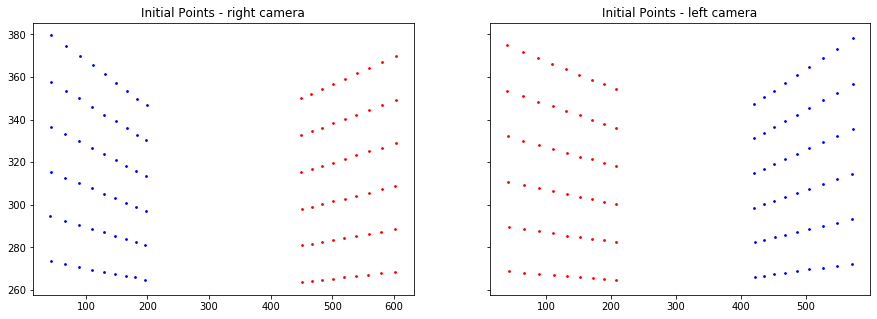

In [141]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True,figsize=(15,5))
ax1.scatter(x_initial_r, y_initial_r, s=3, color = 'b');
ax1.scatter(x_final_r, y_final_r, s=3, color = 'r');
ax1.set_title('Initial Points - right camera');
ax2.scatter(x_initial_l, y_initial_l, s=3, color = 'b');
ax2.scatter(x_final_l, y_final_l, s=3, color = 'r');
ax2.set_title('Initial Points - left camera');

In [142]:
def processing_torch_shapes(data):
    data_arr = []
    for i in range(len(data)):
        data_ =  torch.from_numpy(data[i]).float()
        data_ = torch.cat([data_, torch.ones(data_.shape[:2], dtype = torch.float32).unsqueeze(2)], dim = 2) 
        data_ = data_.reshape(-1,3).T
        data_arr.append(data_)
    return data_arr

In [143]:
P1_r, P2_r, P1_l, P2_l = processing_torch_shapes([initial_points_right_, 
                                                  final_points_right_, 
                                                  initial_points_left_, 
                                                  final_points_left_])

In [144]:
def normalize(x):
    return x[:2]/x[2]

In [145]:
def get_shaped_data(data, num_samples = 100):
    A = np.vstack([
    [
      [ 0, 0, 0, -x * w_, -y * w_, - w * w_, x * y_, y * y_, w * y_ ],
      [ x * w_, y * w_, w * w_, 0, 0, 0, -x * x_, -y * x_, -w * x_ ],
    ]
  for (x, y, w), (x_, y_, w_) in zip(data[0].T[:48*num_samples], data[1].T[:48*num_samples])
])
    return A    

In [146]:
A_r = get_shaped_data([P1_r,P2_r])
A_l = get_shaped_data([P1_l,P2_l])

In [147]:
A_r = torch.from_numpy(A_r).float()
A_l = torch.from_numpy(A_l).float()

### First guess:

In [148]:
h = torch.eye(3,dtype=torch.float32)
h = h.flatten()
h.requires_grad_()

tensor([1., 0., 0., 0., 1., 0., 0., 0., 1.], requires_grad=True)

In [149]:
torch.mean((A_r @ h) ** 2),torch.mean((A_l @ h) ** 2)

(tensor(78869.9141, grad_fn=<MeanBackward0>),
 tensor(65510.1406, grad_fn=<MeanBackward0>))

### Optimization

In [184]:
optim = torch.optim.Adam([h], lr=1e-10)

In [185]:
def loop_optim(A, h, optim, n_iter=100000):
    for i in range(n_iter):
        optim.zero_grad()
        loss = torch.sum((A @ h) ** 2)
        loss.backward()
        optim.step()
    return h

Right camera:

In [162]:
hr_optimized = loop_optim(A_r, h, optim)
last_loss_right = torch.mean((A_r @ hr_optimized) ** 2)
last_loss_right

tensor(0.0016, grad_fn=<MeanBackward0>)

In [165]:
hr_optimized = hr_optimized.detach().reshape(3,3).numpy()
hr_optimized = hr_optimized/(hr_optimized[2,2])
hr_optimized

Left camera:

In [171]:
h = torch.eye(3,dtype=torch.float32)
h = h.flatten()
h.requires_grad_()

tensor([1., 0., 0., 0., 1., 0., 0., 0., 1.], requires_grad=True)

In [186]:
hl_optimized = loop_optim(A_l, h, optim)
last_loss_left = torch.mean((A_l @ hl_optimized) ** 2)
last_loss_left

tensor(0.0020, grad_fn=<MeanBackward0>)

In [187]:
hl_optimized = hl_optimized.detach().reshape(3,3).numpy()
hl_optimized = hl_optimized/(hl_optimized[2,2])
hl_optimized

array([[ 7.7501810e-01, -1.9650115e-02, -2.7785739e+02],
       [-3.1973630e-01,  7.4462152e-01,  1.6014401e+02],
       [-4.2425343e-04, -1.1669054e-04,  1.0000000e+00]], dtype=float32)

### Final Visualization

In [190]:
P1_r = P1_r.detach().numpy()
P1_l = P1_l.detach().numpy()

Text(0.5, 1.0, 'Final Result - left camera')

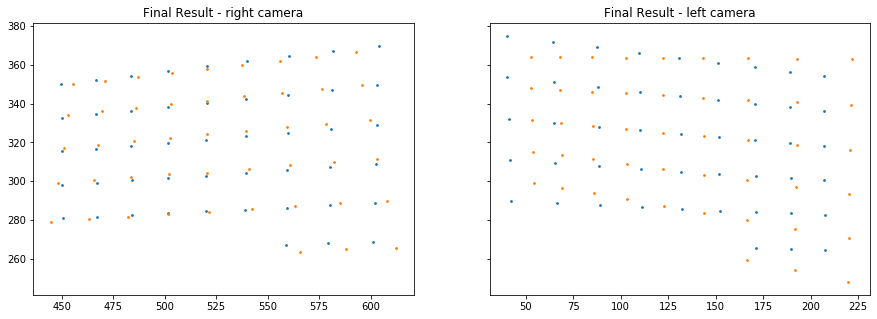

In [192]:
IDX = 90
show_only = slice(48 * IDX, 48 * (IDX + 1))
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True,figsize=(15,5))
ax1.scatter(*normalize(P2_r)[:2, show_only], s=3)
ax1.scatter(*normalize(hr_optimized @ P1_r)[:2, show_only], s=3)
ax1.set_title('Final Result - right camera')
ax2.scatter(*normalize(P2_l)[:2, show_only], s=3)
ax2.scatter(*normalize(hl_optimized @ P1_l)[:2, show_only], s=3)
ax2.set_title('Final Result - left camera')

In [193]:
hr_optimized,hl_optimized

(array([[-1.4234242e-01,  2.8220055e+00,  2.6443402e+02],
        [-8.9791119e-01,  3.9870169e+00, -4.5271432e+02],
        [-4.4160392e-03,  5.5601574e-03,  1.0000000e+00]], dtype=float32),
 array([[ 7.7501810e-01, -1.9650115e-02, -2.7785739e+02],
        [-3.1973630e-01,  7.4462152e-01,  1.6014401e+02],
        [-4.2425343e-04, -1.1669054e-04,  1.0000000e+00]], dtype=float32))